In [1]:
%matplotlib inline

import importlib.util
import math
import os.path
from os import path
import time

from fastai.script import *
from fastai.vision import *
from fastai.callbacks import *
from fastai.distributed import *
from fastai.callbacks.tracker import *
from fastai.utils.ipython import * 
torch.backends.cudnn.benchmark = True
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from torch import nn

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [2]:
# df = pd.read_csv('./labels_sample.csv')
df = pd.read_csv('./labels.csv')
# df = df.head(1000)

In [3]:
len(df)

255530

In [4]:
df.head(5)

,image_name,tags
0,953619,0 1 5 17 38 36 15 6 5 1
1,953958,10 7 15 26 26 21 10 8 1 2
2,954184,0 0 4 8 41 56 10 3 4 0
3,954113,0 1 4 6 48 37 23 5 2 2
4,953980,0 3 6 15 57 39 6 1 1 1


In [5]:
tfms = ([
    flip_lr(p=0.5),
    brightness(change=(0.4,0.6)),
    contrast(scale=(0.7,1.3))
], [])

In [6]:
scores_map = dict(zip(df.image_name, df.tags))
labels = list(scores_map.keys())

In [7]:
assets_not_on_disk = []
for img in labels:
    if not (os.path.exists(os.path.join('./data', str(img)+'.jpg'))):
        assets_not_on_disk.append(img)

In [8]:
len(assets_not_on_disk)

22

In [9]:
df = df[~df.image_name.isin(assets_not_on_disk)]

In [10]:
len(df)

255508

In [11]:
df.head(5)

,image_name,tags
10,953417,0 0 0 5 32 50 23 10 3 1
11,953777,0 3 2 3 13 40 35 21 8 3
12,953756,0 2 3 9 35 50 20 5 2 2
13,954195,0 1 7 26 56 23 6 1 0 2
14,953903,0 1 4 5 33 50 17 9 3 2


In [12]:
datablocks_data = list(zip(
                        df.image_name.apply(
                            lambda x: '{}.jpg'.format(x)), df.tags
                       ))
datablocks_df = pd.DataFrame(datablocks_data, columns = ['name', 'label'])

In [13]:
datablocks_df.head(5)

,name,label
0,953417.jpg,0 0 0 5 32 50 23 10 3 1
1,953777.jpg,0 3 2 3 13 40 35 21 8 3
2,953756.jpg,0 2 3 9 35 50 20 5 2 2
3,954195.jpg,0 1 7 26 56 23 6 1 0 2
4,953903.jpg,0 1 4 5 33 50 17 9 3 2


In [ ]:
# datablocks_df = datablocks_df.head(100000)

In [14]:
# Recompute labels since key is has .jpg extension
scores_map = dict(zip(datablocks_df.name, datablocks_df.label))
labels = list(datablocks_df.name)

In [15]:
len(labels)

255508

In [16]:
class NimaLabelList(CategoryList):
    _processor=None
    def __init__(self, items:Iterator, classes=labels, label_delim:str=None, **kwargs):
        super().__init__(items, classes=classes, **kwargs)

    def get(self, i):
        dist = scores_map[self.items[i]]
        dist = np.array(dist.split(' '), dtype=float)
        return dist

In [17]:
func = lambda o: o.split('/')[1]#print(int((o.split('/')[1]).split('.')[0]));

In [18]:
data = (ImageList.from_df(datablocks_df, path='./data')
        # ImageList.from_csv('./', 'labels_sample.csv', folder='data', suffix='.jpg')
        .split_by_rand_pct()
        .label_from_func(func, label_cls=NimaLabelList)
        .transform(tfms, size=224)
        .databunch(bs=64))

In [19]:
data

ImageDataBunch;

Train: LabelList (204407 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: NimaLabelList
[ 0.  0.  0.  5. 32. 50. 23. 10.  3.  1.],[ 0.  3.  2.  3. 13. 40. 35. 21.  8.  3.],[ 0.  2.  3.  9. 35. 50. 20.  5.  2.  2.],[ 0.  1.  7. 26. 56. 23.  6.  1.  0.  2.],[ 0.  1.  4.  5. 33. 50. 17.  9.  3.  2.]
Path: data;

Valid: LabelList (51101 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: NimaLabelList
[ 0.  1.  3. 14. 41. 50. 35. 12.  6.  0.],[ 3.  3.  5. 14. 47. 59. 42. 20. 17.  3.],[ 0.  1.  0.  3. 33. 41. 38. 20. 13.  3.],[ 1.  1.  3.  7. 30. 40. 42. 30.  8.  5.],[ 3.  7. 10. 18. 43. 28. 20.  3.  2.  0.]
Path: data;

Test: None

In [20]:
data.c

255508

In [21]:
data.c = 10

In [22]:
x,y = next(iter(data.train_dl))

In [23]:
len(x), len(y)

(64, 64)

In [ ]:
# data.show_batch(rows=5, figsize=(9,7))

In [24]:
# learn = cnn_learner(data, models.resnet34, metrics=error_rate)
arch  = models.mobilenet_v2
learner = cnn_learner(data, arch, pretrained=True) #, loss_func=emd)

In [25]:
y_hat = learner.model(x)

In [26]:
y_hat.shape, y.shape

(torch.Size([64, 10]), torch.Size([64, 10]))

In [27]:
y[0], torch.cumsum(y[0], dim=0)

(tensor([ 0.,  0.,  1.,  7., 32., 48., 57., 33., 17.,  8.], device='cuda:0',
        dtype=torch.float64),
 tensor([  0.,   0.,   1.,   8.,  40.,  88., 145., 178., 195., 203.],
        device='cuda:0', dtype=torch.float64))

In [28]:
# (input, target)
def emd(y_hat, y):
    cdf_y = torch.cumsum(y, dim=-1)
    cdf_y_hat = torch.cumsum(y_hat, dim=-1).double()
    power = torch.pow((cdf_y - cdf_y_hat), 2)
    emd = torch.sqrt(torch.mean(power, dim=-1))
    return torch.mean(emd)

In [29]:
emd(y_hat, y)

tensor(147.9147, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)

In [30]:
learner.loss_func

FlattenedLoss of CrossEntropyLoss()

In [31]:
learner.loss_func = emd

In [32]:
learner.loss_func

<function __main__.emd(y_hat, y)>

In [33]:
with gpu_mem_restore_ctx():
    learner.fit_one_cycle(4)

epoch,train_loss,valid_loss,time
0,38.121002,37.366974,07:18
1,37.699669,36.536866,07:18
2,36.695259,36.073732,07:18
3,36.050461,36.024489,07:18


In [34]:
learner.save('stage-1')

In [35]:
learner.unfreeze()

In [36]:
learner.load('stage-1');

In [37]:
learner.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


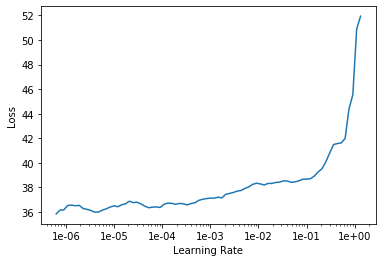

In [38]:
learner.recorder.plot()

In [39]:
learner.unfreeze()
with gpu_mem_restore_ctx():
    learner.fit_one_cycle(2, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,time
0,36.448463,35.988281,07:27
1,35.919136,35.911668,07:25


In [40]:
learner.save('stage-2')

In [41]:
pred = learner.model(x)

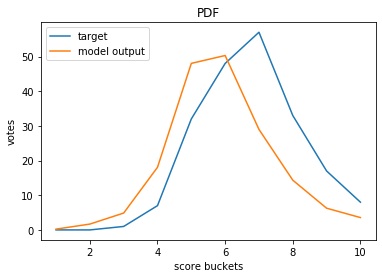

In [42]:
scores = np.arange(1,11)
plt.plot(scores, y[0], label='target');
plt.plot(scores, pred[0], label='model output');
plt.title("PDF")
plt.xlabel("score buckets")
plt.ylabel("votes");
plt.legend();

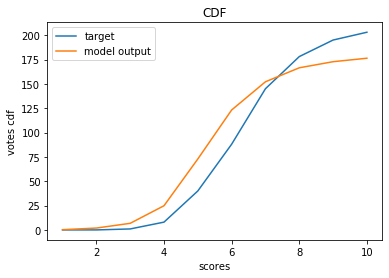

In [43]:
scores = np.arange(1,11)
plt.plot(scores, torch.cumsum(y[0], dim=-1), label='target');
plt.plot(scores, torch.cumsum(pred[0], dim=-1), label='model output');
plt.title("CDF")
plt.xlabel("scores")
plt.ylabel("votes cdf");
plt.legend();